In [1]:
import ast
import warnings
import textwrap

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.auto import tqdm

# NLTK packages
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

# Spacy
import spacy

warnings.filterwarnings("ignore")

# For better visualizations
sns.set(style="ticks", palette="muted", color_codes=True)

plt.rcParams['axes.labelsize'] = 15
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['font.weight'] = 'bold'

# downloading corpus
nltk.download('stopwords')
nltk.download('punkt')

stopwords = set(stopwords.words("english"))

# Remove 'not' from stopword list
stopwords.remove('not')

# Load the spaCy English model
# https://github.com/explosion/spaCy/issues/6498
nlp = spacy.load("en_core_web_lg", disable=["parser", 'ner'])
# nlp.add_pipe('sentencizer')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
def wrap_text(text):
    return textwrap.fill(text, width=85)

In [3]:
df=pd.read_csv("qatarairways_tweets_sentiments.csv", parse_dates=['date'])

In [4]:
df.head()

link  \
0  https://twitter.com/olibatt/status/17364271384...   
1  https://twitter.com/intoxicat3/status/17363417...   
2  https://twitter.com/snigdhanandan/status/17363...   
3  https://twitter.com/YOUNGPGTECH/status/1736266...   
4  https://twitter.com/snigdhanandan/status/17362...   

                                                text  \
0  🙄 Once you announce something on the status of...   
1  @qrsupport I need help for the transit for my ...   
2  @qrsupport I wish I had read the IATA laws ear...   
3  This is not good at all, cash should be accept...   
4  @qrsupport @qatarairways I had made a case the...   

                       date  Likes  Comments hashtags  \
0 2023-12-17 16:44:00+00:00      1         1       []   
1 2023-12-17 11:05:00+00:00      0         0       []   
2 2023-12-17 09:26:00+00:00      0         1       []   
3 2023-12-17 06:05:00+00:00      0         1       []   
4 2023-12-17 05:15:00+00:00      2         4       []   

                                   sentiment  
0   {'label': 'neutral', 'score': 0.7836185}  
1   {'label': 'neutral', 'score': 0.7484599}  
2  {'label': 'negative', 'score': 0.9295316}  
3  {'label': 'negative', 'score': 0.9209826}  
4  {'label': 'neutral', 'score': 0.60687053}

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65619 entries, 0 to 65618
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype              
---  ------     --------------  -----              
 0   link       65619 non-null  object             
 1   text       65619 non-null  object             
 2   date       65619 non-null  datetime64[ns, UTC]
 3   Likes      65619 non-null  int64              
 4   Comments   65619 non-null  int64              
 5   hashtags   65619 non-null  object             
 6   sentiment  65619 non-null  object             
dtypes: datetime64[ns, UTC](1), int64(2), object(4)
memory usage: 3.5+ MB


# Preprocess Text for EDA

In [6]:
# https://github.com/kootenpv/contractions
import contractions

eg_str = df.loc[25, 'text']
print(wrap_text(eg_str))
print()
print(wrap_text(contractions.fix(eg_str)))

@qrsupport @qatarairways I’m genuinely disappointed that my exist seat that I booked
for my 16hrs outward flight tomorrow to LAX was given to another passenger when I
only changed the date of my return flight. I’ve been a privilege member for 10+
years. Wasn’t offered a solution.

@qrsupport @qatarairways I am genuinely disappointed that my exist seat that I booked
for my 16hrs outward flight tomorrow to LAX was given to another passenger when I
only changed the date of my return flight. I have been a privilege member for 10+
years. Was not offered a solution.


In [7]:
# Remove stopwords function
def remove_sw(text):
    tokenized_text = word_tokenize(text)
    # Remove stopwords and those words that is of length<=2
    processed_text = (word for word in tokenized_text if not word in stopwords and len(word) > 2)

    return " ".join(processed_text)

print(wrap_text(eg_str))
print()
print(wrap_text(remove_sw(contractions.fix(eg_str))))

@qrsupport @qatarairways I’m genuinely disappointed that my exist seat that I booked
for my 16hrs outward flight tomorrow to LAX was given to another passenger when I
only changed the date of my return flight. I’ve been a privilege member for 10+
years. Wasn’t offered a solution.

qrsupport qatarairways genuinely disappointed exist seat booked 16hrs outward flight
tomorrow LAX given another passenger changed date return flight privilege member 10+
years Was not offered solution


In [8]:
# Lemmatization
# https://stackoverflow.com/a/75215495/15937542
def lemmatize_pipe(text_col):
    
    docs = nlp.pipe(text_col)
    lemmatized_col = [lemmatize_text_spacy(doc) for doc in docs]

    return lemmatized_col


def lemmatize_text_spacy(doc):

    # Extract lemmatized words
    # The word refunded does not get lemmatized, hence adding this special condition
    lemmatized_words = (token.lemma_ if token.text != "refunded" else "refund" for token in doc)

    # Join the lemmatized words to form the lemmatized text
    lemmatized_text = ' '.join(lemmatized_words)

    return lemmatized_text

print(wrap_text(eg_str))
print()

doc=nlp(remove_sw(contractions.fix(eg_str)))
print(wrap_text(lemmatize_text_spacy(doc)))

@qrsupport @qatarairways I’m genuinely disappointed that my exist seat that I booked
for my 16hrs outward flight tomorrow to LAX was given to another passenger when I
only changed the date of my return flight. I’ve been a privilege member for 10+
years. Wasn’t offered a solution.

qrsupport qatarairways genuinely disappointed exist seat book 16hrs outward flight
tomorrow LAX give another passenger change date return flight privilege member 10 +
year be not offer solution


In [9]:
df = (
    df.drop_duplicates(subset='text', ignore_index=True)
    .assign(
        
        # Extract usernames
        users=lambda x: x['link'].str.extract(r'twitter\.com/(.*?)/status', expand=False),

        # For the `cleaned_text` column, first the `text` undergoes all preprocessing steps such as
        # removing user hanldes, urls, remove empty spaces, stopwords, etc.
        # Finally, the whole proprocessed `text` column is then inputted into the 
        # "lemmatize_pipe" function to process lemmatization quickly.
        cleaned_text=lambda x: lemmatize_pipe(
            # lower case
            x['text'].str.lower()
            
            # Remove all userhandles
            .str.replace(r'@\w+', ' ', regex=True)
            
            # Remove all url links
            .str.replace(r'https*.*? *|www\..*? *|bit\..*? *', " ", 
                         regex=True)

            # Apply Contractions function
            .apply(contractions.fix)

            # Remove everything other characters extept alphabets
            .str.replace(r'[^a-z]', ' ', regex=True)

            # Remove all extra spaces
            .str.replace('\s+', " ", regex=True)

            # Remove leading and trailing spaces
            .str.strip()

            # Remove stopwords
            .apply(remove_sw)
            ),
        
        # Create new column that contain sentiment label
        sntmnt_lbl=lambda x: (x['sentiment']
                        .apply(ast.literal_eval)
                        .apply(lambda x: x['label'])),

        # Create new column that contain score for sentiment label
        score=lambda x: (x['sentiment']
                        .apply(ast.literal_eval)
                        .apply(lambda x: x['score'])),
    )
    # drop sentiment column
    .drop('sentiment', axis=1)

    # remove those rows with just empty text after preprocessing
    .loc[lambda x:x['cleaned_text'].ne('')]
    .reset_index(drop=True)
)

df.head()

link  \
0  https://twitter.com/olibatt/status/17364271384...   
1  https://twitter.com/intoxicat3/status/17363417...   
2  https://twitter.com/snigdhanandan/status/17363...   
3  https://twitter.com/YOUNGPGTECH/status/1736266...   
4  https://twitter.com/snigdhanandan/status/17362...   

                                                text  \
0  🙄 Once you announce something on the status of...   
1  @qrsupport I need help for the transit for my ...   
2  @qrsupport I wish I had read the IATA laws ear...   
3  This is not good at all, cash should be accept...   
4  @qrsupport @qatarairways I had made a case the...   

                       date  Likes  Comments hashtags          users  \
0 2023-12-17 16:44:00+00:00      1         1       []        olibatt   
1 2023-12-17 11:05:00+00:00      0         0       []     intoxicat3   
2 2023-12-17 09:26:00+00:00      0         1       []  snigdhanandan   
3 2023-12-17 06:05:00+00:00      0         1       []    YOUNGPGTECH   
4 2023-12-17 05:15:00+00:00      2         4       []  snigdhanandan   

                                        cleaned_text sntmnt_lbl     score  
0  announce something status restart cwl doh rout...    neutral  0.783618  
1  need help transit mother upcoming layover hour...    neutral  0.748460  
2  wish read iata law early thank not even try he...   negative  0.929532  
3              not good cash accept pwople look biko   negative  0.920983  
4  make case moment land iberia qatar put iberia ...    neutral  0.606871

In [10]:
# Compare original vs final preprocessed text
print(wrap_text(eg_str))
print()
print(wrap_text(df.loc[25, 'cleaned_text']))

@qrsupport @qatarairways I’m genuinely disappointed that my exist seat that I booked
for my 16hrs outward flight tomorrow to LAX was given to another passenger when I
only changed the date of my return flight. I’ve been a privilege member for 10+
years. Wasn’t offered a solution.

genuinely disappointed exist seat book hrs outward flight tomorrow lax give another
passenger change date return flight privilege member year not offer solution


In [11]:
eg_str = df.loc[24549, 'text']
print(wrap_text(eg_str))
print()
print(wrap_text(df.loc[24549, 'cleaned_text']))

Thank you for replying after 300 years. I’ll be ever more grateful if you refunded my
money. Your customer service isn’t really doing your customers any service at all.
#Disappointed

thank reply year ever grateful refund money customer service not really customer
service disappoint


In [12]:
# from keybert import KeyBERT

# model = KeyBERT('distilbert-base-nli-mean-tokens')

# def extract_keywords(texts):

#     kw_list = model.extract_keywords(
#         texts,
#         keyphrase_ngram_range=(1, 2),
#         stop_words=None,
#         top_n=3,
#         use_mmr=True,
#         diversity=0.7
#     )

#     keywords=[",".join((k[0] for k in kw_tup)) for kw_tup in kw_list]
    
#     return keywords

# batch_size=8
# nbr_of_batches=int(np.ceil(len(df)/batch_size))

# df_batches = np.array_split(df['cleaned_text'].to_list(), nbr_of_batches)

# keyword_list=[]

# for batch in tqdm(df_batches):
#     keywords_from_batch = extract_keywords(texts=batch)
#     keyword_list.extend(keywords_from_batch)

## Keyword/phrase Extraction

In [13]:
from joblib import Parallel, delayed
import yake

# Initialize YAKE extractor outside the function for better performance
yake_kw = yake.KeywordExtractor(n=2, top=5, windowsSize=100)

def yake_extract_kw(text):
    try:
        # Extracting keywords 
        KeyWords = yake_kw.extract_keywords(text) 

        # Displaying top 5 keywords 
        keywords = ",".join((kw for kw, _ in KeyWords if "qatar" not in kw))
        return keywords
    
    except Exception as e:
        print(f"Error processing text: {text}")
        print(f"Error details: {e}")
        return ""

# https://stackoverflow.com/questions/42220458/what-does-the-delayed-function-do-when-used-with-joblib-in-python
def process_texts_parallel(texts, n_jobs=-1):
    results = Parallel(n_jobs=n_jobs)(delayed(yake_extract_kw)(text) for text in texts)
    return results

In [14]:
df['keywords']=process_texts_parallel(df['cleaned_text'].tolist())

In [15]:
df[['cleaned_text', 'keywords']].head(10)

cleaned_text  \
0  announce something status restart cwl doh rout...   
1  need help transit mother upcoming layover hour...   
2  wish read iata law early thank not even try he...   
3              not good cash accept pwople look biko   
4  make case moment land iberia qatar put iberia ...   
5                                           do thank   
6                                              thank   
7  could let senior management know ban bribe fli...   
8                              say month see nothing   
9  good evening fly london kathmandu via doha hou...   

                                            keywords  
0  return dec,cwl doh,restart cwl,status restart,...  
1  kindly assist,transit mother,mother upcoming,u...  
2  iata law,law early,customer strand,strand fore...  
3      good cash,cash accept,accept pwople,biko,good  
4  make case,madrid tomorrow,iberia flight,put ib...  
5                                                     
6                                                     
7  senior management,ban bribe,bribe flight,fligh...  
8                                              month  
9  good evening,evening fly,fly london,london kat...

In [16]:
df.loc[5, "keywords"]

''

In [17]:
df.loc[df['keywords'].str.contains("qatar")]

Empty DataFrame
Columns: [link, text, date, Likes, Comments, hashtags, users, cleaned_text, sntmnt_lbl, score, keywords]
Index: []

In [18]:
def get_kw_by_sentiment(sentiment, hastag=False):

    if hastag:
        kw = (
            df.loc[df['hashtags'].ne("[]") & df['sntmnt_lbl'].eq(sentiment), 'hashtags']
            .apply(ast.literal_eval)
            .explode()
            .str.lower()
            .str.cat(sep=" ")
        )
    else:
        kw = (
            df.loc[df['keywords'].ne('') & df['sntmnt_lbl'].eq(sentiment)]
            .loc[:, 'keywords']
            .replace(" ", "_", regex=True)
            .replace(",", " ", regex=True)
            .str.cat(sep=" ")
        )

    return kw

In [19]:
from wordcloud import WordCloud

def create_wc(text_data, colormap=None):
    # Generate the word cloud
    wordcloud = WordCloud(width=1200, 
                          height=600,
                          colormap=colormap, 
                          background_color="black").generate(text_data)
    
    # Display the word cloud using matplotlib
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

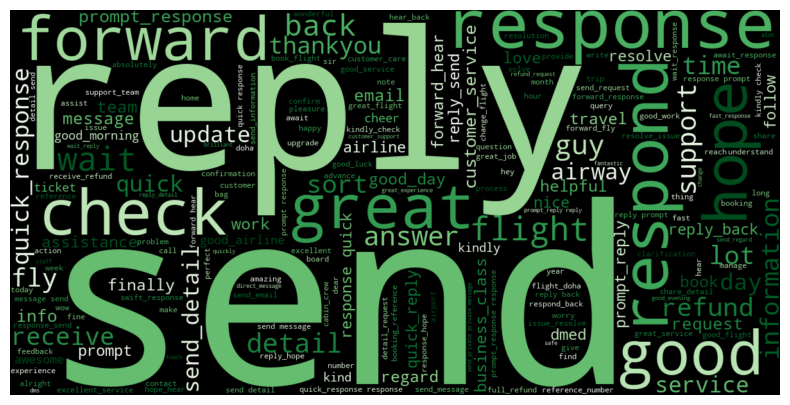

In [20]:
# Positive Keywords
text_data = get_kw_by_sentiment(sentiment='positive')
create_wc(text_data, colormap='Greens')

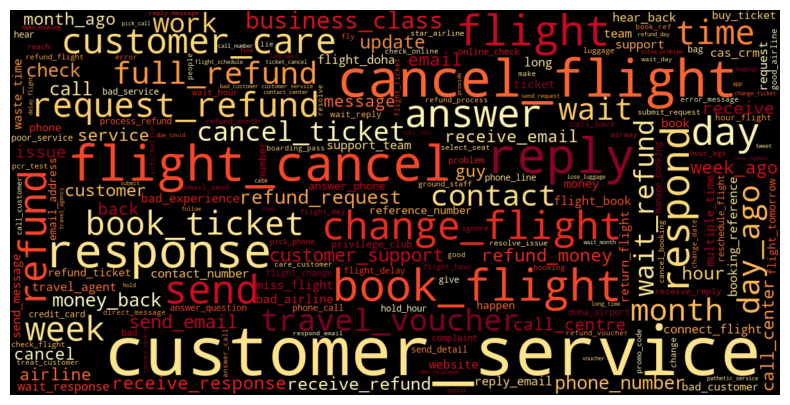

In [21]:
# Negative Keywords
text_data = get_kw_by_sentiment(sentiment='negative')
create_wc(text_data, colormap='YlOrRd')

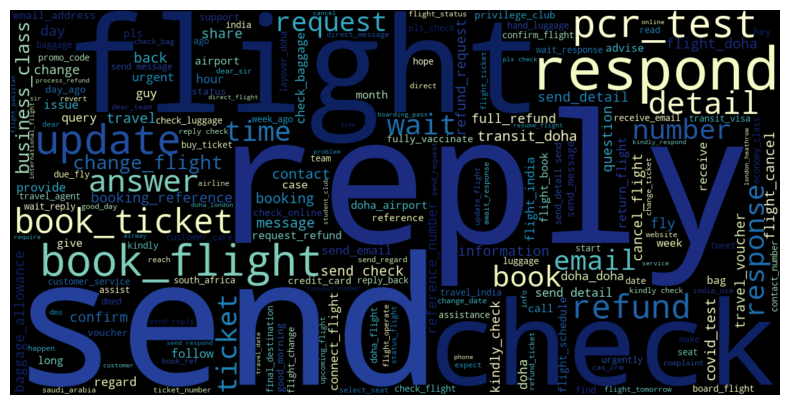

In [22]:
# Neutral Keywords
text_data = get_kw_by_sentiment(sentiment='neutral')
create_wc(text_data, colormap='YlGnBu')

# Tweets Timeline

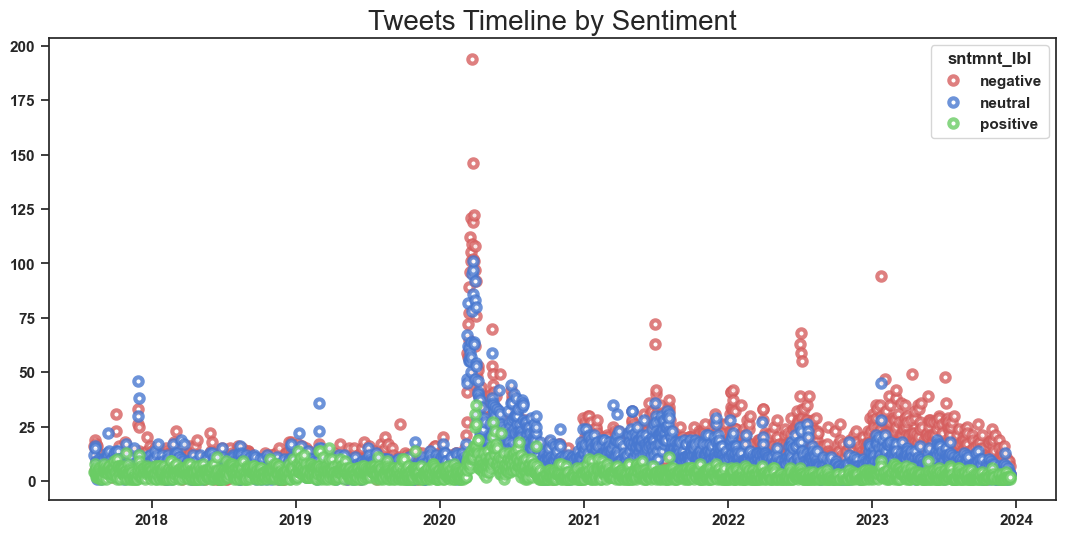

In [23]:
ax = (
    df.groupby([df['date'].dt.date, 'sntmnt_lbl']).size()
    .unstack('sntmnt_lbl')
    .plot(figsize=(13, 6), 
          linestyle='', 
          marker='o', 
          color=['r', 'b', 'g'], 
          alpha=0.8, 
          mfc='w', 
          markeredgewidth=3)
)

ax.set_title("Tweets Timeline by Sentiment")
ax.set_xlabel("");

In [24]:
(
    df.loc[df['keywords'].ne(""), 'keywords']
    .str.split(",")
    .explode()
    .value_counts()
    .nlargest(5000)
    .index
)

Index(['send', 'reply', 'check', 'customer service', 'flight', 'response',
       'respond', 'wait', 'book flight', 'refund',
       ...
       'airline cheat', 'ehteraz app', 'put refund', 'update detail',
       'civil aviation', 'money spend', 'adelaide doha', 'inbox message',
       'vacation', 'dad flight'],
      dtype='object', name='keywords', length=5000)

In [25]:
def top_20_kw_strings(kw):
    
    # Create Top 20 keyword series
    ################################
    query=f"""
        keywords!='' and sntmnt_lbl in ('negative', 'positive')
    """

    kw_df = (
        # Filter rows with no strings and with +ve and -ve sentiments only
        df.query(query)

        # split all keywords of each row to lists
        .assign(keywords=lambda x: x['keywords'].str.split(","))

        # convert to only 1 keyword per row
        .explode(column='keywords')

        # filter out rows with the required keyword
        .query(f"keywords.str.contains('{kw}')")

        # assign a column with value 1, so that it can be summed during aggregation
        .assign(count=1)

        # group by keywords and get count of +ve and -ve sentiments
        .groupby(['keywords', 'sntmnt_lbl'])['count'].sum()

        # pivot sentiment column
        .unstack('sntmnt_lbl')

        # Some keywords may have only -ve category (or vice versa). 
        # If so, create a new column for the missing sentiment with value 0
        .assign(negative=lambda x: x['negative'] if 'negative' in x.columns else 0,
                positive=lambda x: x['positive'] if 'positive' in x.columns else 0)

        # convert to integer data type and create new column that has total of -ve and +ve
        .assign(negative=lambda x: x['negative'].astype("Int64"),
                positive=lambda x: x['positive'].astype("Int64"),
                total=lambda x: x['negative'] + x['positive'])

        # select only the top 20 by total
        .nlargest(20, columns='total')

        # drop total column
        .drop('total', axis=1)

        # Ensure the columns are of this order
        .reindex(columns=['negative', 'positive'])
    )

    return kw_df

In [26]:
def kw_sntmnt_timeline(kw):
    
    # Create keyword frequncy timeline
    ##################################
    
    start=df['date'].dt.date.min()
    end=df['date'].dt.date.max()

    tl_df = (   
        # query rows with required keyword and filter out rows with neutral sentiment
        df.query(f"keywords.str.contains('{kw}') and sntmnt_lbl!='neutral'")

        # create new column containing date value
        # This is useful during aggregating by date and getting count of keyword per day
        .assign(only_date=lambda x: pd.to_datetime(x['date'].dt.date))

        # group by date and sentiment label and get count
        .groupby(['only_date', 'sntmnt_lbl']).size()

        # pivot sentiment col
        .unstack('sntmnt_lbl')
        
        # Some keywords may have only -ve category (or vice versa). 
        # If so, create a new column for the missing sentiment with value null
        .assign(negative=lambda x: x['negative'] if 'negative' in x.columns else np.nan,
                positive=lambda x: x['positive'] if 'positive' in x.columns else np.nan)

        # Ensure date range is from aug 2017 to dec 2023 and ensure right order of columns
        .reindex(pd.date_range(start, end), columns=['negative', 'positive'])

        # convert to integer data type and create new column
        .assign(negative=lambda x: x['negative'].astype("Int64"),
                positive=lambda x: x['positive'].astype("Int64"))
    )

    return tl_df

In [27]:
def get_ht_sntmnt_from_kw(kw):
    
    # dataframe with concatenated hastags by sentiments
    ht_df = (
        df.query(f"keywords.str.contains('{kw}') and hashtags!='[]' and sntmnt_lbl!='neutral'")
        .loc[:, ['sntmnt_lbl', 'hashtags']]
        .assign(hashtags=lambda x: x['hashtags'].apply(ast.literal_eval))
        .explode(column='hashtags')
        .assign(hashtags=lambda x: x['hashtags'].str.lower())
        .loc[lambda x: ~x['hashtags'].isin(['#qatarairways', '#qatar', '#qrsupport'])]
        .loc[lambda x: ~x['hashtags'].str.contains(r'^#[0-9]+$')]
        .groupby('sntmnt_lbl')['hashtags'].agg(lambda x: ' '.join(x))
    )

    # Negative hashtag
    try:
        neg_ht = ht_df.loc[lambda x: x.index=='negative'].values[0]
    except IndexError:
        neg_ht = 'no_hashtag'

    # Positive hashtag
    try:
        pos_ht = ht_df.loc[lambda x: x.index=='positive'].values[0]
    except IndexError:
        pos_ht = 'no_hashtag'

    return neg_ht, pos_ht

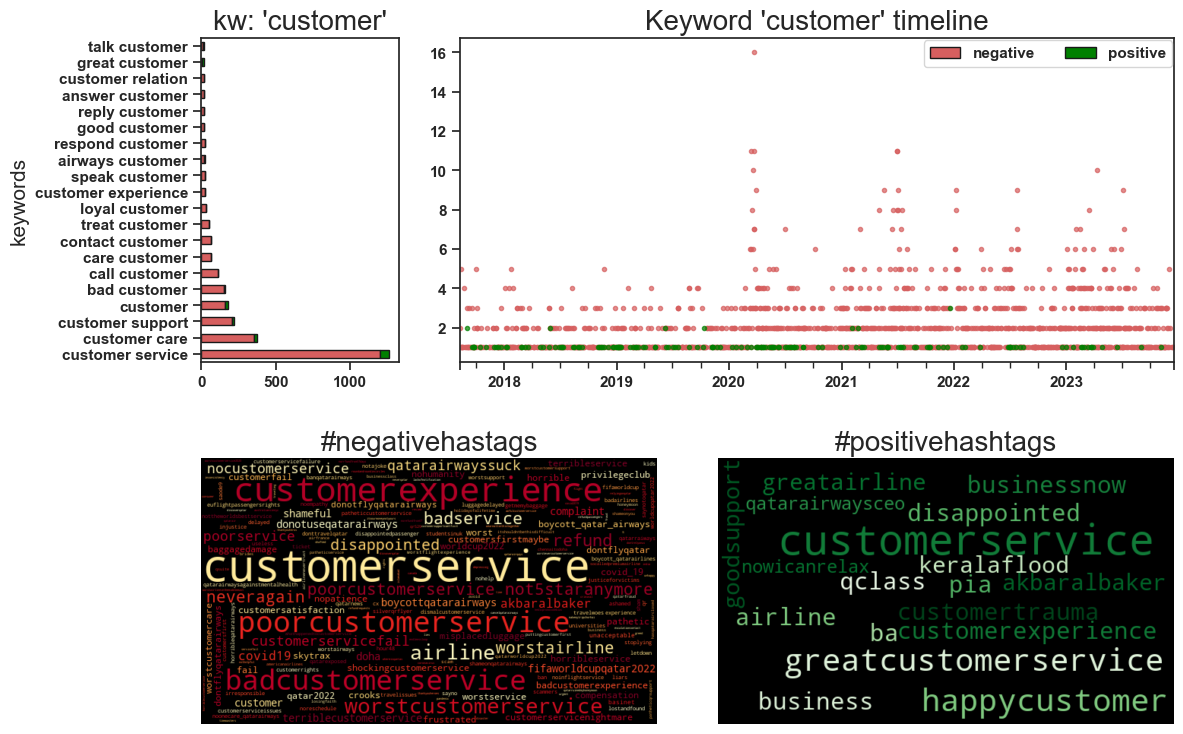

In [28]:
def analyze_kw(kw):

    # https://www.geeksforgeeks.org/how-to-create-different-subplot-sizes-in-matplotlib/

    fig = plt.figure()
    fig.set_figheight(7.8)
    fig.set_figwidth(12)

    ax0 = plt.subplot2grid(shape=(2, 4), loc=(0, 0))
    ax1 = plt.subplot2grid(shape=(2, 4), loc=(0, 1), colspan=3)
    ax2 = plt.subplot2grid(shape=(2, 4), loc=(1, 0), colspan=2)
    ax3 = plt.subplot2grid(shape=(2, 4), loc=(1, 2), colspan=2)

    # Colors for sentiment
    color=['r', 'green']

    # Create Top 20 keyword Bargraph
    ################################

    subplot_title="" if len(kw)>25 else kw

    top_20_kw_strings_df = top_20_kw_strings(kw=kw)

    # Plot bargraph
    top_20_kw_strings_df.plot(kind='barh', 
                                stacked=True, 
                                edgecolor='k', 
                                ax=ax0, 
                                color=color, 
                                legend=None)

    ax0.set_title(f"kw: '{subplot_title}'")

    # Create keyword frequncy timeline
    ##################################

    kw_sntmnt_timeline_df = kw_sntmnt_timeline(kw=kw)

    kw_sntmnt_timeline_df.plot(ax=ax1, 
                            linestyle="", 
                            marker='.', 
                            alpha=0.7, 
                            color=color, 
                            legend=None)

    ax1.set_title(f"Keyword '{subplot_title}' timeline")
    ax1.set_xlabel("")
    
    max_ylim=kw_sntmnt_timeline(kw).max().max()

    if  max_ylim < 10: 
        ax1.set_ylim(0, 10)
        ax1.set_yticks(range(0, 12, 2))

    # Highlighting Qatar flight ban time period
    # ax1.fill_between(x=("2020-03-18", "2020-04-01"), y1=0, y2=max_ylim+2, color='b', alpha = 0.5)

    # Hashtag Worldclouds by sentiment
    ##################################
    
    neg_ht, pos_ht = get_ht_sntmnt_from_kw(kw)

    for ht, ax, cmap, title in zip([neg_ht, pos_ht],
                             [ax2, ax3],
                             ['YlOrRd', 'Greens'],
                             ["#negativehastags", "#positivehashtags"]):

        wordcloud = WordCloud(width=600, height=350, colormap=cmap).generate(ht)
        
        ax.set_title(title)
        ax.imshow(wordcloud, interpolation="bilinear")
        ax.axis("off")
        ax.grid(None)
        

    labels=['negative', 'positive']
    fig.legend(labels, loc='center', bbox_to_anchor=(0.88, 0.92), ncol=len(labels), 
               bbox_transform=fig.transFigure)

    plt.tight_layout()
    plt.show()

analyze_kw(kw='customer')

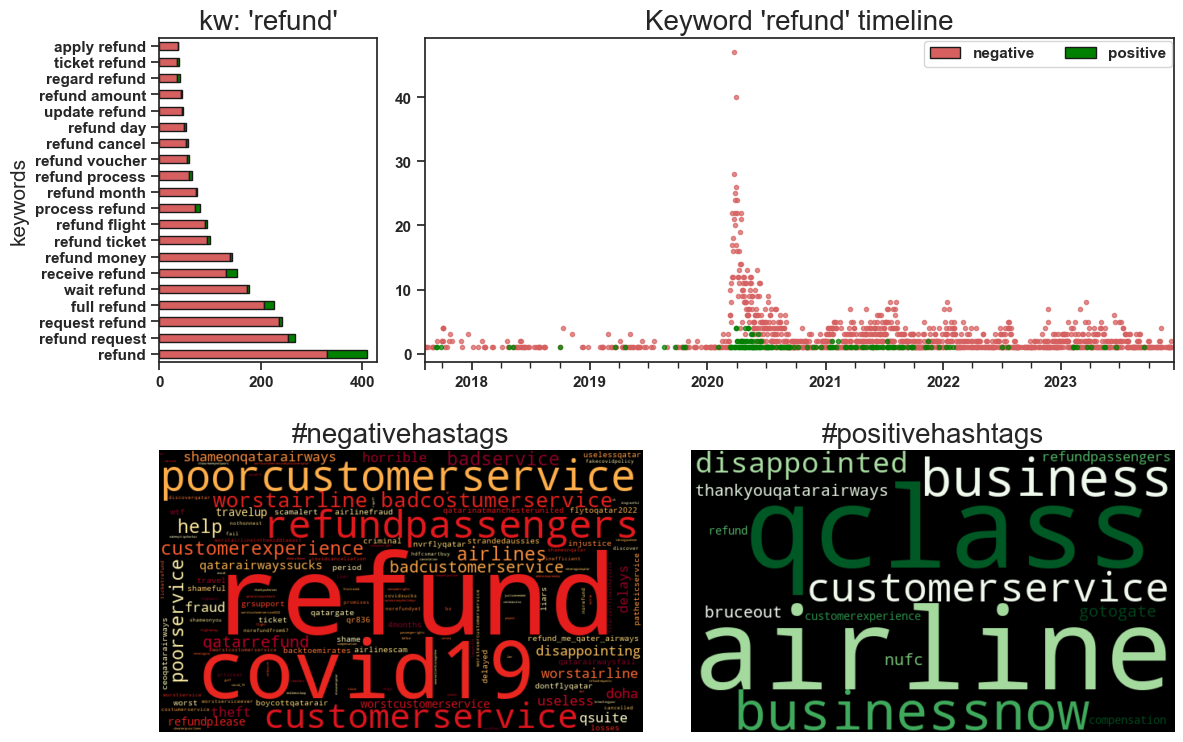

In [29]:
analyze_kw(kw='refund')

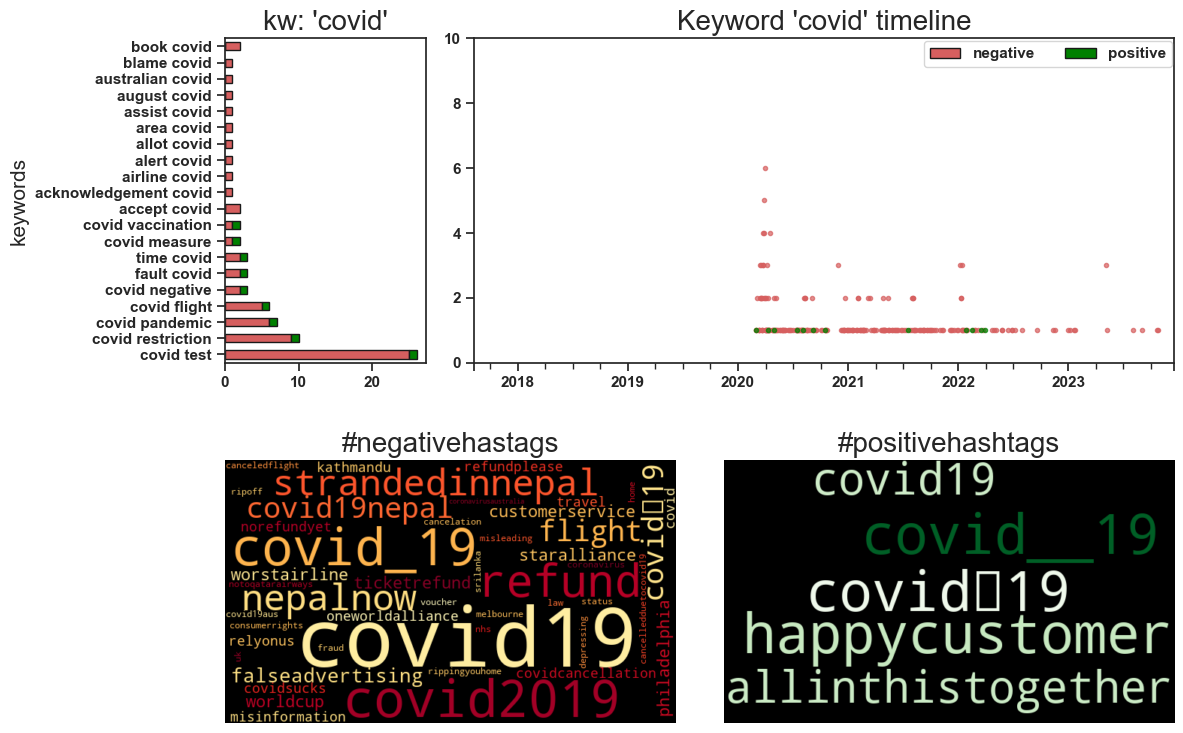

In [30]:
analyze_kw(kw='covid')

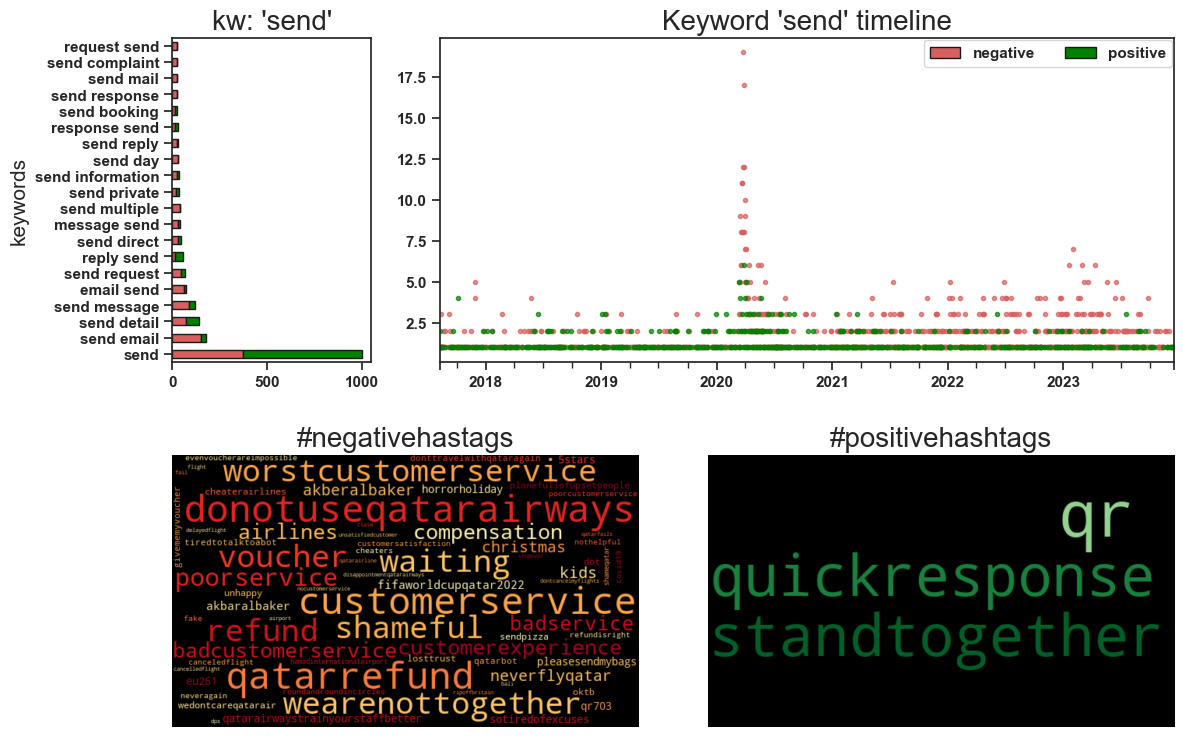

In [31]:
analyze_kw(kw='send')

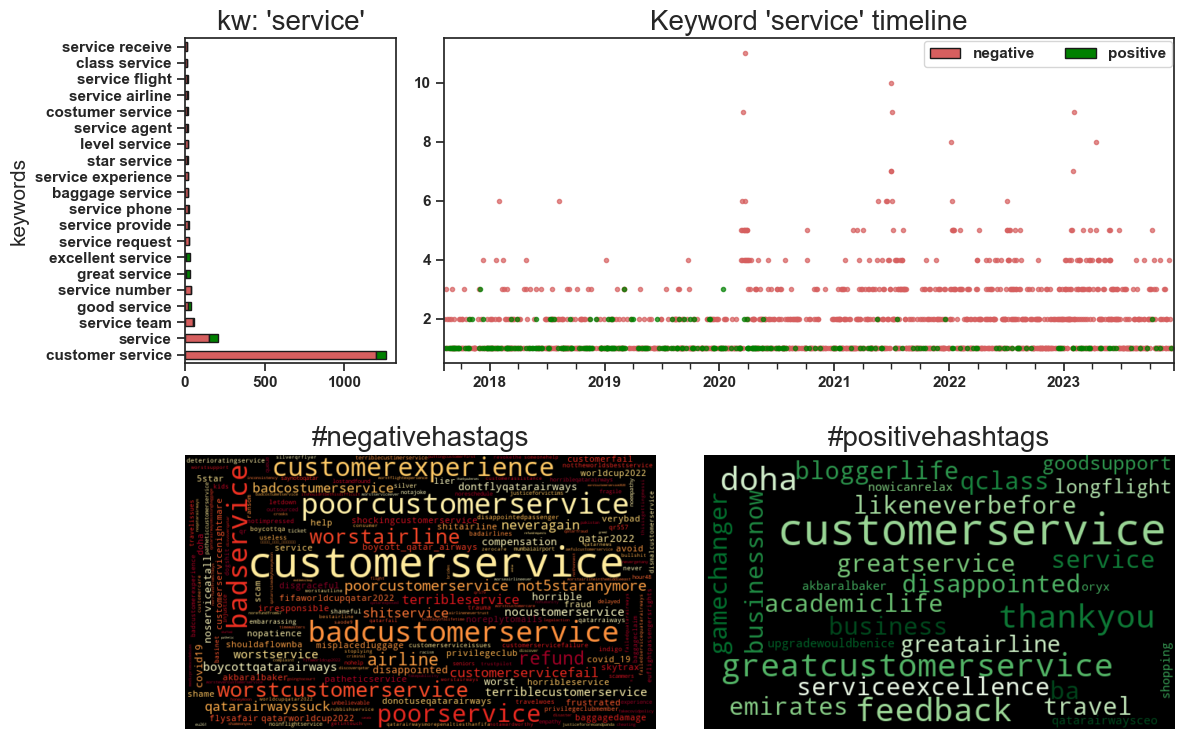

In [32]:
analyze_kw(kw='service')

In [33]:
# Missclassification by roBERTa. This wassupposed to be of negative sentiment.

(
    df.query("hashtags.str.contains('disappoint', case=False) and sntmnt_lbl=='positive'")
    .loc[:, ['text', 'cleaned_text', 'sntmnt_lbl', 'keywords']]
    .values
)

array([['Thank you for replying after 300 years. I’ll be ever more grateful if you refunded my money. Your customer service isn’t really doing your customers any service at all. #Disappointed',
        'thank reply year ever grateful refund money customer service not really customer service disappoint',
        'positive',
        'customer service,service disappoint,refund money,grateful refund,money customer']],
      dtype=object)

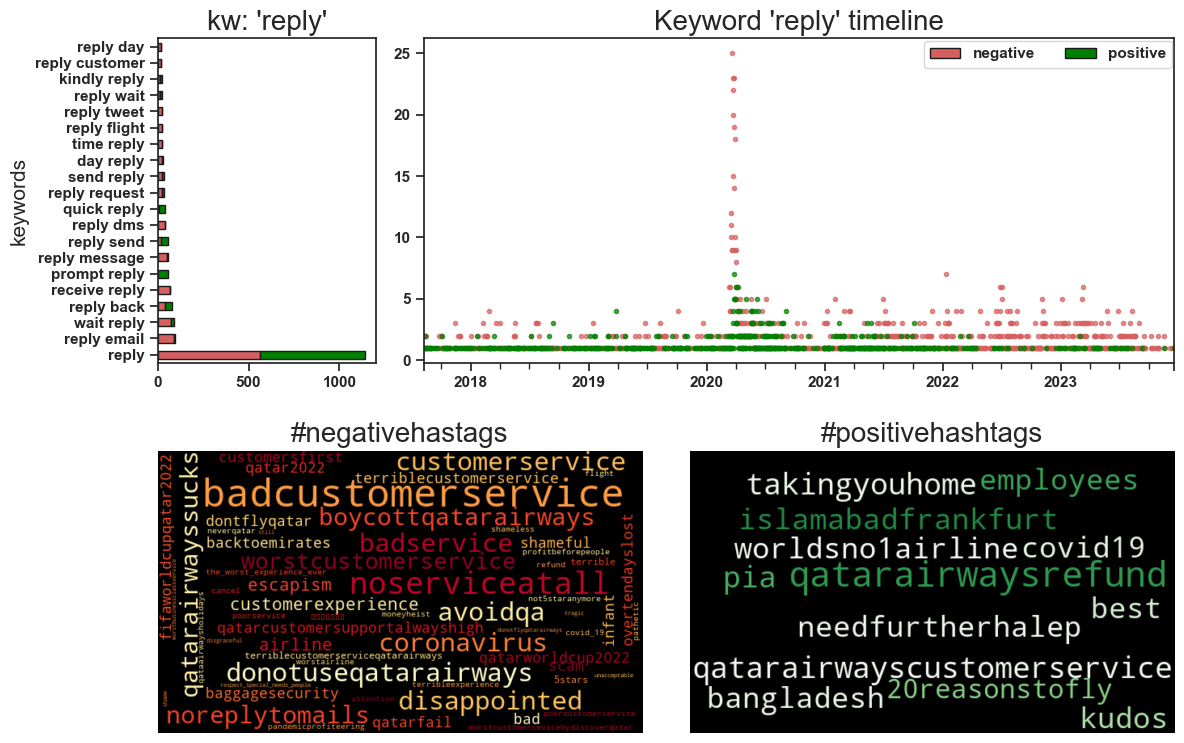

In [34]:
analyze_kw(kw='reply')

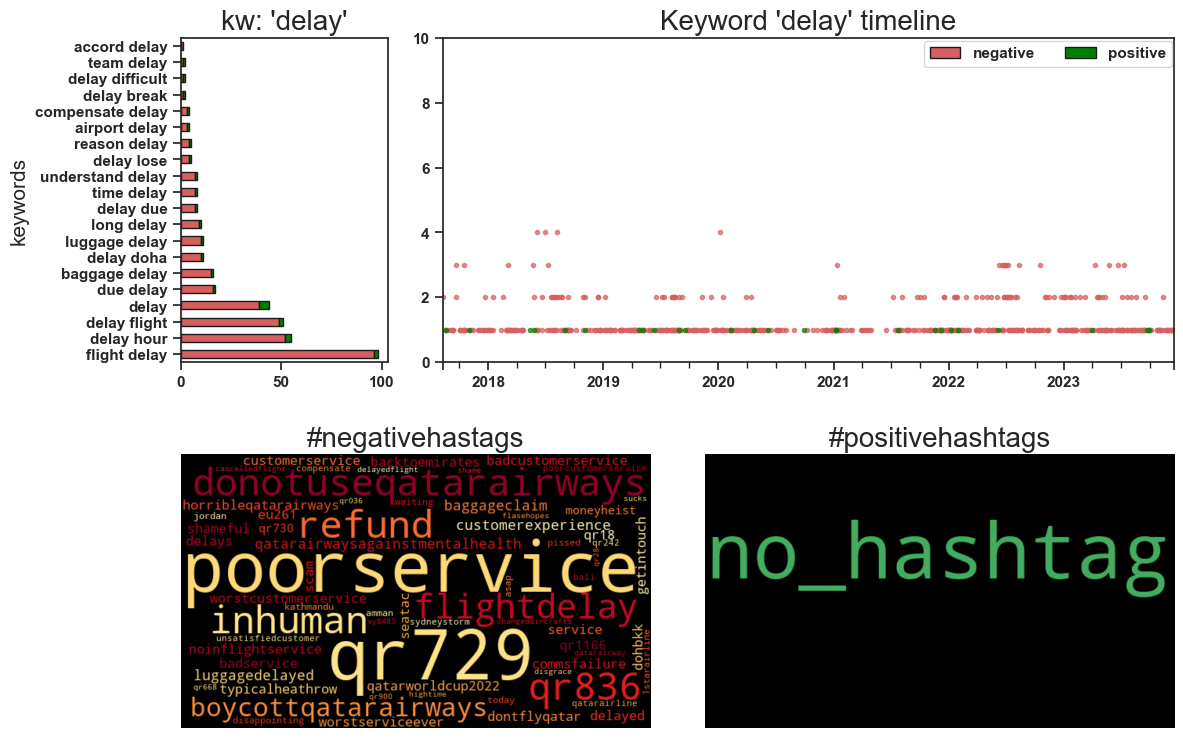

In [35]:
analyze_kw(kw='delay')

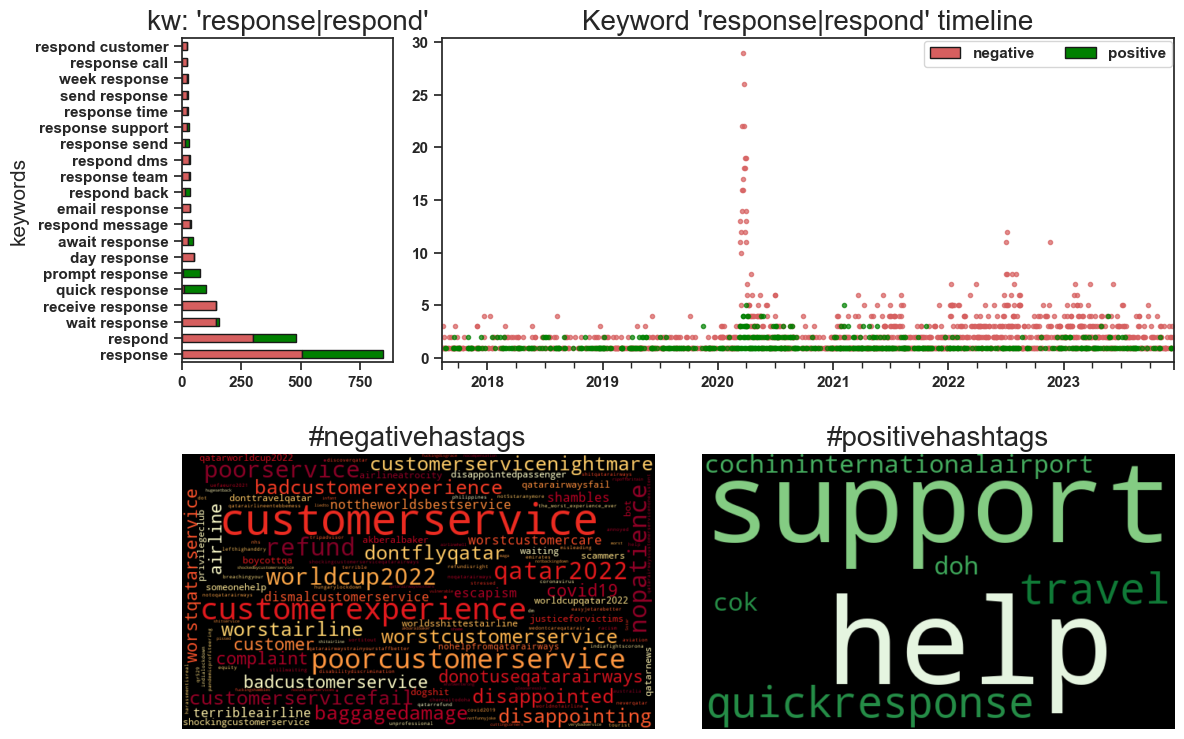

In [36]:
analyze_kw(kw='response|respond')

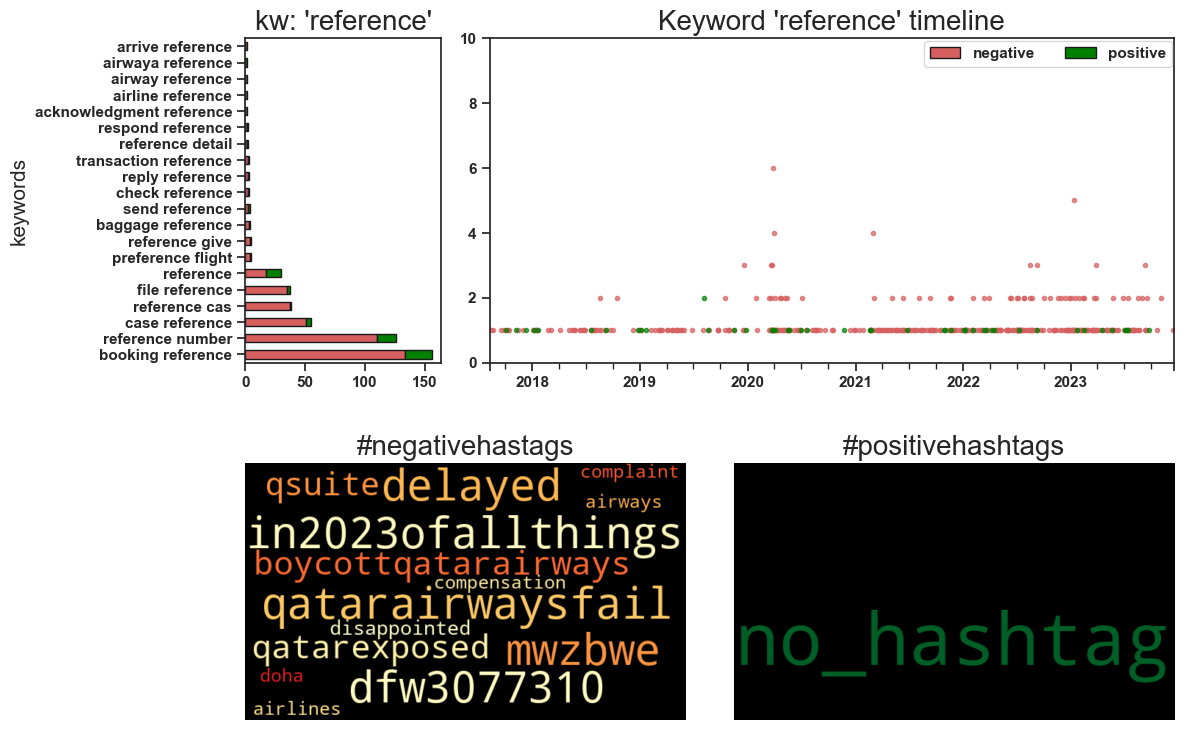

In [37]:
analyze_kw(kw='reference')

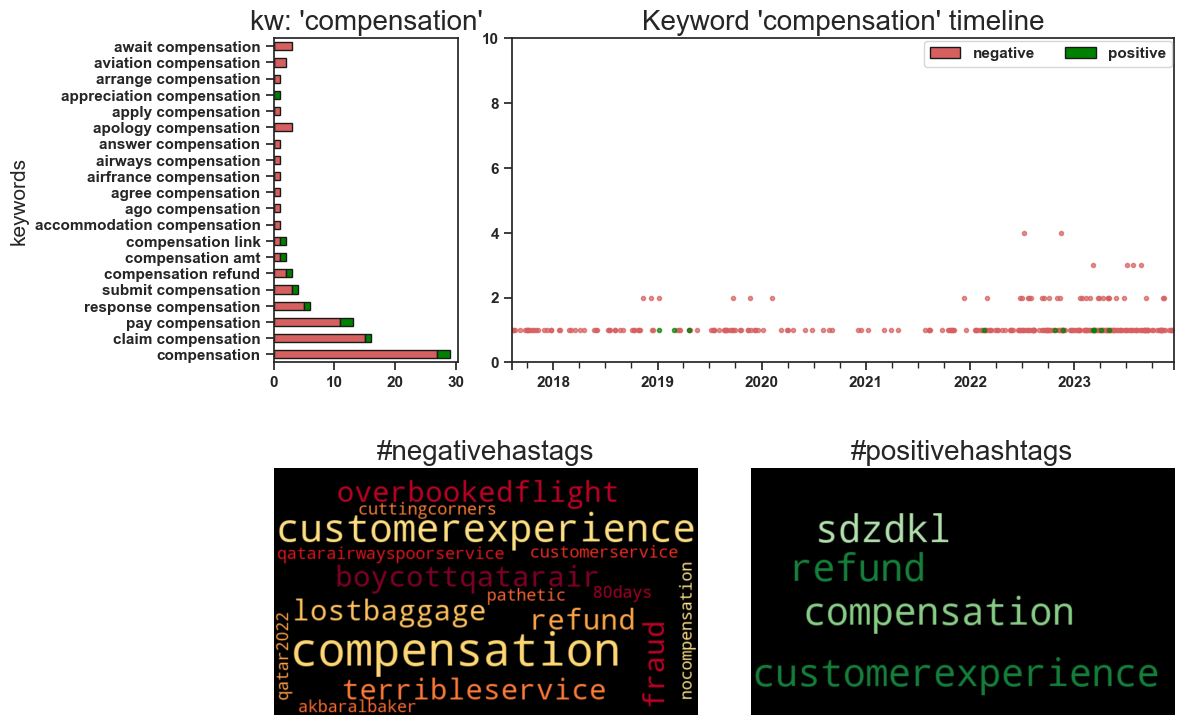

In [38]:
analyze_kw(kw='compensation')

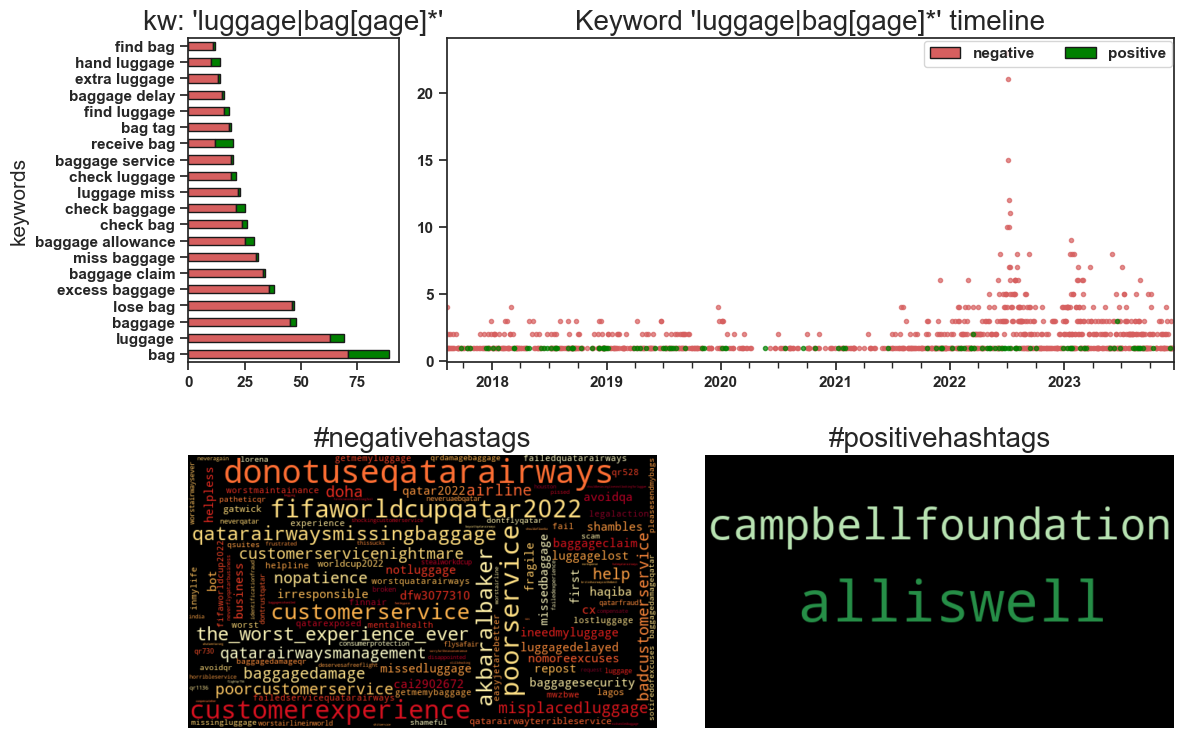

In [39]:
analyze_kw(kw='luggage|bag[gage]*')

# Users

In [40]:
# Analyzing those tweets by a users that tweeted the most in a single day

def analyze_usertweets_by_date(user, date):

    end_of_date=(pd.Timedelta('1D') + pd.to_datetime(date)).strftime('%Y-%m-%d')

    text_data=(
        df.loc[df['date'].between(date, end_of_date) & df['users'].eq(user)]
        .sort_values('date')
        .loc[:, 'keywords']
        .str.split(",")
        .explode()
        .replace(" ", "_", regex=True)
        .str.cat(sep=" ")
    )

    create_wc(text_data)

In [41]:
# Getting list of users that tweeted the most in a single day with their 
# tweet count for that day
(
    df.assign(only_date=lambda x: x['date'].dt.date)
    .groupby(['only_date', 'users']).size()
    .to_frame('tweet_count')
    .reset_index()
    .assign(tweet_count_rank=lambda x: (x.groupby('only_date')['tweet_count']
                                        .rank('dense', ascending=False)
                                        .astype(int)))
    .loc[lambda x: x['tweet_count_rank'].eq(1)]
    .drop('tweet_count_rank', axis=1)
    .nlargest(10, columns='tweet_count')    
)

only_date            users  tweet_count
803    2017-10-02  KiranKu78839646           25
10965  2019-09-22   shiraz_shafqat           23
24869  2020-11-01    stevesukkie93           19
1383   2017-11-16           HT4599           18
15403  2020-03-25         Leo_P999           17
3683   2018-04-27         hamzag22           15
43092  2023-01-03      LaverdeCaro           15
3669   2018-04-26         hamzag22           14
44875  2023-03-16   TanyaT55736757           14
46891  2023-07-05        krupamaya           14

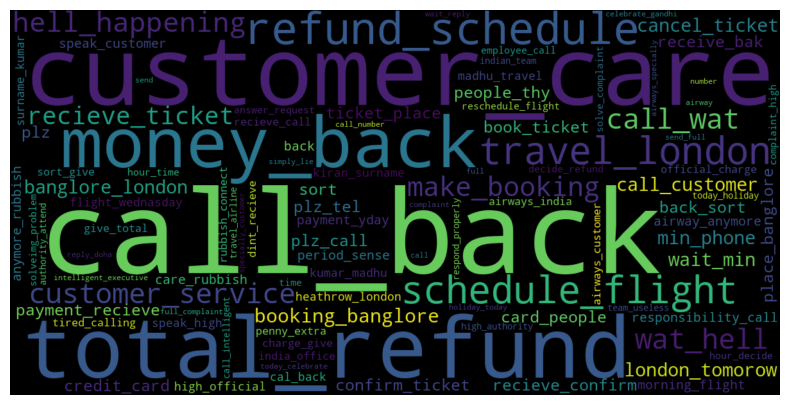

In [42]:
user='KiranKu78839646'
date='2017-10-02'

analyze_usertweets_by_date(user, date)

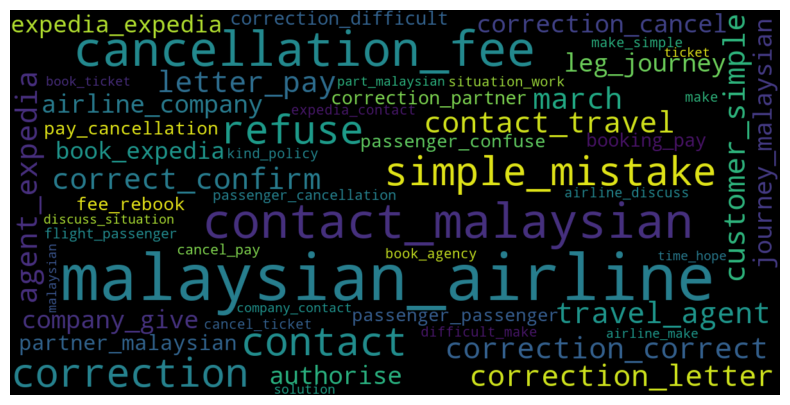

In [43]:
user='TanyaT55736757'
date='2023-03-16'

analyze_usertweets_by_date(user, date)

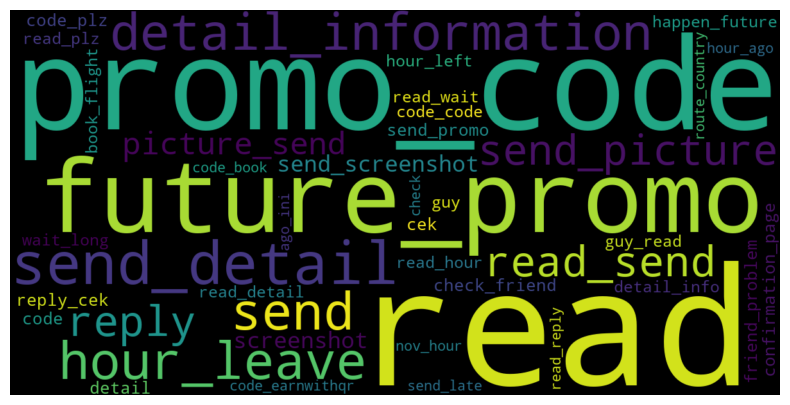

In [44]:
user='stevesukkie93'
date='2020-11-01'

analyze_usertweets_by_date(user, date)